In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import numpy as np
import torch

def evaluate_model(model, val_loader, device, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    sensitivity = recall_score(all_labels, all_preds)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0

    # Print results
    print(f"\nResults for {model_name}:")
    print("Confusion Matrix:")
    print(f"[[TN: {tn}, FP: {fp}]\n [FN: {fn}, TP: {tp}]]")
    print(f"Accuracy:    {accuracy:.2%}")
    print(f"F1 Score:    {f1:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

    return {
        "model": model_name,
        "accuracy": accuracy,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist()
    }

In [15]:
import os
import pandas as pd
import random
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
N_PER_CLASS = 200 # 200 healthy + 200 carious

# === Load and match labels to files ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]

# Extract numeric image ID (e.g., "1021" from "1021.jpg")
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()

# Build correct file paths like "1021/tooth_4.jpg"
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)

# Filter to only existing image files
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]
print("Resolved example path:", os.path.join(img_dir, df.iloc[0]['Filename']))
print("Total usable images:", len(df))

# === Balanced Sampling: 100 healthy + 100 carious (or max available)
healthy_pool = df[df["Label"] == 0]
carious_pool = df[df["Label"] == 1]

available_N = min(len(healthy_pool), len(carious_pool), N_PER_CLASS)
if available_N == 0:
    raise ValueError("Not enough images available to train.")

healthy_df = healthy_pool.sample(n=available_N, random_state=42)
carious_df = carious_pool.sample(n=available_N, random_state=42)
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Proceeding with {available_N} healthy and {available_N} carious images")

#  Dataset Class
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        if self.transform:
            image = self.transform(image)
        return image, label

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Prepare Dataset & Split
dataset = ToothDataset(df, img_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

# Load Pretrained ResNet18 
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: healthy and carious
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

# Evaluation 
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.2%}")


✅ Resolved example path: C:/Users/shawn/Downloads/SMART/BoundingBoxCrops\53\tooth_1.jpg
✅ Total usable images: 25167
✅ Proceeding with 200 healthy and 200 carious images


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 24.8125
Epoch 2/10, Loss: 14.2980
Epoch 3/10, Loss: 12.6963
Epoch 4/10, Loss: 12.1497
Epoch 5/10, Loss: 11.2435
Epoch 6/10, Loss: 9.9666
Epoch 7/10, Loss: 9.6477
Epoch 8/10, Loss: 8.8225
Epoch 9/10, Loss: 9.6852
Epoch 10/10, Loss: 8.3331
✅ Validation Accuracy: 61.25%


In [14]:
# Count of carious
total_df = pd.read_csv("C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv")
carious_count = (total_df["Label"] == 1).sum()
print(f"Total number of carious (unhealthy) teeth: {carious_count}")


🦷 Total number of carious (unhealthy) teeth: 386


In [19]:
metrics = evaluate_model(model, val_loader, device, model_name = "ResNet18")


Results for ResNet18:
Confusion Matrix:
[[TN: 36, FP: 6]
 [FN: 25, TP: 13]]
Accuracy:    61.25%
F1 Score:    0.46
Sensitivity: 0.34
Specificity: 0.86


In [2]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"

# === Load and match labels to files ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]
print("Resolved example path:", os.path.join(img_dir, df.iloc[0]['Filename']))
print("Total usable images:", len(df))

# === Imbalanced Sampling: 1000 healthy + 384 carious ===
healthy_pool = df[df["Label"] == 0]
carious_pool = df[df["Label"] == 1]

available_healthy = min(len(healthy_pool), 384)
available_carious = min(len(carious_pool), 384)

healthy_df = healthy_pool.sample(n=available_healthy, random_state=42)
carious_df = carious_pool.sample(n=available_carious, random_state=42)

df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Proceeding with {available_healthy} healthy and {available_carious} carious images")

# === Dataset Class ===
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        if self.transform:
            image = self.transform(image)
        return image, label

# === Transforms (with 256×256 input size) ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# === Prepare Dataset & Split ===
dataset = ToothDataset(df, img_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

# === Load Pretrained DenseNet121 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

# === Loss and Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Training Loop ===
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[DenseNet] Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

# === Evaluation ===
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"DenseNet Validation Accuracy: {correct / total:.2%}")


Resolved example path: C:/Users/shawn/Downloads/SMART/BoundingBoxCrops\53\tooth_1.jpg
Total usable images: 25167
Proceeding with 384 healthy and 384 carious images


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[DenseNet] Epoch 1/10, Loss: 29.2882
[DenseNet] Epoch 2/10, Loss: 25.9762
[DenseNet] Epoch 3/10, Loss: 25.2126
[DenseNet] Epoch 4/10, Loss: 25.0810
[DenseNet] Epoch 5/10, Loss: 25.1006
[DenseNet] Epoch 6/10, Loss: 24.6130
[DenseNet] Epoch 7/10, Loss: 24.7670
[DenseNet] Epoch 8/10, Loss: 23.8542
[DenseNet] Epoch 9/10, Loss: 23.9781
[DenseNet] Epoch 10/10, Loss: 23.6098
DenseNet Validation Accuracy: 56.49%


In [22]:
evaluate_model(model, val_loader, device, model_name="DenseNet121")


Results for DenseNet121:
Confusion Matrix:
[[TN: 17, FP: 28]
 [FN: 4, TP: 31]]
Accuracy:    60.00%
F1 Score:    0.66
Sensitivity: 0.89
Specificity: 0.38


{'model': 'DenseNet121',
 'accuracy': 0.6,
 'f1': 0.6595744680851063,
 'sensitivity': 0.8857142857142857,
 'specificity': 0.37777777777777777,
 'confusion_matrix': [[17, 28], [4, 31]]}

In [23]:
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
N_PER_CLASS = 200

#  Load and match labels to files
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]
print("Resolved example path:", os.path.join(img_dir, df.iloc[0]['Filename']))
print("Total usable images:", len(df))

# Balanced Sampling 
healthy_pool = df[df["Label"] == 0]
carious_pool = df[df["Label"] == 1]
available_N = min(len(healthy_pool), len(carious_pool), N_PER_CLASS)
if available_N == 0:
    raise ValueError("Not enough images available to train.")

healthy_df = healthy_pool.sample(n=available_N, random_state=42)
carious_df = carious_pool.sample(n=available_N, random_state=42)
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Using {available_N} healthy and {available_N} carious images")

#Dataset Class 
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms 
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet expects 224x224 input
    transforms.ToTensor(),
])

# Prepare Dataset & Split
dataset = ToothDataset(df, img_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

# === Load EfficientNet ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # Update classifier head
model = model.to(device)

# Loss and Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[EfficientNet] Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

# === Run Evaluation ===
evaluate_model(model, val_loader, device, model_name="EfficientNet B0")

C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\shawn/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


Resolved example path: C:/Users/shawn/Downloads/SMART/BoundingBoxCrops\53\tooth_1.jpg
Total usable images: 25167
Using 200 healthy and 200 carious images


100%|██████████| 20.5M/20.5M [00:05<00:00, 4.00MB/s]


[EfficientNet] Epoch 1/10, Loss: 14.4840
[EfficientNet] Epoch 2/10, Loss: 12.6367
[EfficientNet] Epoch 3/10, Loss: 10.7391
[EfficientNet] Epoch 4/10, Loss: 7.6083
[EfficientNet] Epoch 5/10, Loss: 5.5176
[EfficientNet] Epoch 6/10, Loss: 6.5397
[EfficientNet] Epoch 7/10, Loss: 5.2428
[EfficientNet] Epoch 8/10, Loss: 4.1031
[EfficientNet] Epoch 9/10, Loss: 2.9675
[EfficientNet] Epoch 10/10, Loss: 6.2179

📊 EfficientNet B0 Results:
Confusion Matrix:
[[TN: 22, FP: 15]
 [FN: 18, TP: 25]]
Accuracy:    58.75%
F1 Score:    0.60
Sensitivity: 0.58
Specificity: 0.59


In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from collections import defaultdict

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
IMG_SIZE = 256
K = 5
BATCH_SIZE = 16
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Data ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]

# Sample 1000 healthy + 384 carious
healthy_df = df[df["Label"] == 0].sample(n=500, random_state=42)
carious_df = df[df["Label"] == 1].sample(n=384, random_state=42)
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# === Dataset Class ===
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        return self.transform(image), label

# === Transforms with Data Augmentation ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # small shift
    transforms.ToTensor(),
])

# === Evaluation Helper ===
def compute_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    sens = recall_score(all_labels, all_preds)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return acc, f1, sens, spec

# === Model Factory ===
def build_model(name):
    if name == "ResNet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif name == "DenseNet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif name == "EfficientNetB0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    return model.to(DEVICE)

# === K-Fold Cross-Validation ===
results = defaultdict(list)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
dataset = ToothDataset(df, img_dir, transform)

for model_name in ["ResNet18", "DenseNet121", "EfficientNetB0"]:
    print(f"\n Evaluating {model_name} with {K}-fold CV")

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Label"])):
        print(f"  Fold {fold + 1}/{K}")
        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, num_workers=2)

        model = build_model(model_name)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Train
        for epoch in range(EPOCHS):
            model.train()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate
        acc, f1, sens, spec = compute_metrics(model, val_loader)
        results[model_name].append({
            "fold": fold + 1,
            "accuracy": acc,
            "f1": f1,
            "sensitivity": sens,
            "specificity": spec
        })

# === Summary Table ===
print("\n Average Results Across Folds:\n")
summary = []

for model_name in results:
    avg = pd.DataFrame(results[model_name]).mean(numeric_only=True)
    print(f"{model_name}:")
    print(f"  Accuracy:    {avg['accuracy']:.2%}")
    print(f"  F1 Score:    {avg['f1']:.2f}")
    print(f"  Sensitivity: {avg['sensitivity']:.2f}")
    print(f"  Specificity: {avg['specificity']:.2f}\n")
    summary.append({
        "Model": model_name,
        "Accuracy": avg["accuracy"],
        "F1": avg["f1"],
        "Sensitivity": avg["sensitivity"],
        "Specificity": avg["specificity"]
    })

summary_df = pd.DataFrame(summary)



🔁 Evaluating ResNet18 with 5-fold CV
  Fold 1/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 2/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 3/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 4/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 5/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔁 Evaluating DenseNet121 with 5-fold CV
  Fold 1/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 2/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 3/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 4/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 5/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔁 Evaluating EfficientNetB0 with 5-fold CV
  Fold 1/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 2/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 3/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 4/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Fold 5/5


C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shawn\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



📊 Average Results Across Folds:

ResNet18:
  Accuracy:    55.43%
  F1 Score:    0.38
  Sensitivity: 0.41
  Specificity: 0.67

DenseNet121:
  Accuracy:    55.21%
  F1 Score:    0.46
  Sensitivity: 0.47
  Specificity: 0.61

EfficientNetB0:
  Accuracy:    63.70%
  F1 Score:    0.58
  Sensitivity: 0.58
  Specificity: 0.68



In [15]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights
from collections import defaultdict

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
IMG_SIZE = 256
K = 5
BATCH_SIZE = 16
EPOCHS = 15
UNFREEZE_EPOCH = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and Subsample Data ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]

# Sample 1500 healthy + all 384 carious
healthy_df = df[df["Label"] == 0].sample(n=1500, random_state=42)
carious_df = df[df["Label"] == 1]
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f" Using {len(healthy_df)} healthy and {len(carious_df)} carious teeth (Total: {len(df)})")

# === Dataset Class ===
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        return self.transform(image), label

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Metric Function ===
def compute_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    sens = recall_score(all_labels, all_preds)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return acc, f1, sens, spec

# === Model Builder ===
def build_model():
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = models.efficientnet_b0(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    for param in model.features.parameters():
        param.requires_grad = False
    return model.to(DEVICE)

# === Cross-Validation Training ===
results = defaultdict(list)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Label"])):
    print(f"\n Fold {fold + 1}/{K}")
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_dataset = ToothDataset(train_df, img_dir, train_transform)
    val_dataset = ToothDataset(val_df, img_dir, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)

    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Weighted loss
    labels_array = df["Label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_array), y=labels_array)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        if epoch == UNFREEZE_EPOCH:
            for param in model.features.parameters():
                param.requires_grad = True
            print(" Unfroze full model for fine-tuning")

        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

    acc, f1, sens, spec = compute_metrics(model, val_loader)
    results["EfficientNetB0"].append({
        "fold": fold + 1,
        "accuracy": acc,
        "f1": f1,
        "sensitivity": sens,
        "specificity": spec
    })

# === Print Results ===
print("\nAverage Results Across Folds:\n")
summary = []
for model_name in results:
    avg = pd.DataFrame(results[model_name]).mean(numeric_only=True)
    print(f"{model_name}:")
    print(f"  Accuracy:    {avg['accuracy']:.2%}")
    print(f"  F1 Score:    {avg['f1']:.2f}")
    print(f"  Sensitivity: {avg['sensitivity']:.2f}")
    print(f"  Specificity: {avg['specificity']:.2f}\n")
    summary.append({
        "Model": model_name,
        "Accuracy": avg["accuracy"],
        "F1": avg["f1"],
        "Sensitivity": avg["sensitivity"],
        "Specificity": avg["specificity"]
    })

summary_df = pd.DataFrame(summary)


✅ Using 1500 healthy and 384 carious teeth (Total: 1884)

🔁 Fold 1/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 2/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 3/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 4/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 5/5
🔓 Unfroze full model for fine-tuning

📊 Average Results Across Folds:

EfficientNetB0:
  Accuracy:    65.07%
  F1 Score:    0.43
  Sensitivity: 0.65
  Specificity: 0.65



In [29]:
torch.save(model.state_dict(), "C:/Users/shawn/Downloads/SMART/EfficientNetB0_final_fold.pth")


In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import DenseNet121_Weights
from collections import defaultdict

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
IMG_SIZE = 256
K = 5
BATCH_SIZE = 16
EPOCHS = 15
UNFREEZE_EPOCH = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and Subsample Data ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]

# Sample 1500 healthy + all 384 carious
healthy_df = df[df["Label"] == 0].sample(n=1500, random_state=42)
carious_df = df[df["Label"] == 1]
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"✅ Using {len(healthy_df)} healthy and {len(carious_df)} carious teeth (Total: {len(df)})")

# === Dataset Class ===
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        return self.transform(image), label

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Metric Function ===
def compute_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    sens = recall_score(all_labels, all_preds)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return acc, f1, sens, spec

# === Model Builder ===
def build_model():
    weights = DenseNet121_Weights.IMAGENET1K_V1
    model = models.densenet121(weights=weights)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    for param in model.features.parameters():
        param.requires_grad = False
    return model.to(DEVICE)

# === Cross-Validation Training ===
results = defaultdict(list)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Label"])):
    print(f"\nFold {fold + 1}/{K}")
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_dataset = ToothDataset(train_df, img_dir, train_transform)
    val_dataset = ToothDataset(val_df, img_dir, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)

    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Weighted loss
    labels_array = df["Label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_array), y=labels_array)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        if epoch == UNFREEZE_EPOCH:
            for param in model.features.parameters():
                param.requires_grad = True
            print(" Unfroze full model for fine-tuning")

        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

    acc, f1, sens, spec = compute_metrics(model, val_loader)
    results["DenseNet121"].append({
        "fold": fold + 1,
        "accuracy": acc,
        "f1": f1,
        "sensitivity": sens,
        "specificity": spec
    })

# === Print Results ===
print("\n Average Results Across Folds:\n")
summary = []
for model_name in results:
    avg = pd.DataFrame(results[model_name]).mean(numeric_only=True)
    print(f"{model_name}:")
    print(f"  Accuracy:    {avg['accuracy']:.2%}")
    print(f"  F1 Score:    {avg['f1']:.2f}")
    print(f"  Sensitivity: {avg['sensitivity']:.2f}")
    print(f"  Specificity: {avg['specificity']:.2f}\n")
    summary.append({
        "Model": model_name,
        "Accuracy": avg["accuracy"],
        "F1": avg["f1"],
        "Sensitivity": avg["sensitivity"],
        "Specificity": avg["specificity"]
    })

summary_df = pd.DataFrame(summary)


✅ Using 1500 healthy and 384 carious teeth (Total: 1884)

🔁 Fold 1/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 2/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 3/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 4/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 5/5
🔓 Unfroze full model for fine-tuning

📊 Average Results Across Folds:

DenseNet121:
  Accuracy:    69.80%
  F1 Score:    0.43
  Sensitivity: 0.57
  Specificity: 0.73



In [28]:
torch.save(model.state_dict(), "C:/Users/shawn/Downloads/SMART/densenet121_final_fold.pth")


In [17]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from collections import defaultdict

# === CONFIG ===
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"
IMG_SIZE = 256
K = 5
BATCH_SIZE = 16
EPOCHS = 15
UNFREEZE_EPOCH = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and Subsample Data ===
df = pd.read_csv(csv_path)
df = df[df['Label'].isin([0, 1])]
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)
df = df[df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))]

# Sample 1500 healthy + all 384 carious
healthy_df = df[df["Label"] == 0].sample(n=1500, random_state=42)
carious_df = df[df["Label"] == 1]
df = pd.concat([healthy_df, carious_df]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Using {len(healthy_df)} healthy and {len(carious_df)} carious teeth (Total: {len(df)})")

# === Dataset Class ===
class ToothDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["Filename"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["Label"])
        return self.transform(image), label

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Metric Function ===
def compute_metrics(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    sens = recall_score(all_labels, all_preds)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    return acc, f1, sens, spec

# === Model Builder ===
def build_model():
    weights = ResNet50_Weights.IMAGENET1K_V1
    model = models.resnet50(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 2)
    for param in model.layer1.parameters():
        param.requires_grad = False
    for param in model.layer2.parameters():
        param.requires_grad = False
    return model.to(DEVICE)

# === Cross-Validation Training ===
results = defaultdict(list)
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Label"])):
    print(f"\n Fold {fold + 1}/{K}")
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

    train_dataset = ToothDataset(train_df, img_dir, train_transform)
    val_dataset = ToothDataset(val_df, img_dir, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)

    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Weighted loss
    labels_array = df["Label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_array), y=labels_array)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    for epoch in range(EPOCHS):
        if epoch == UNFREEZE_EPOCH:
            for param in model.parameters():
                param.requires_grad = True
            print("🔓 Unfroze full model for fine-tuning")

        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

    acc, f1, sens, spec = compute_metrics(model, val_loader)
    results["ResNet50"].append({
        "fold": fold + 1,
        "accuracy": acc,
        "f1": f1,
        "sensitivity": sens,
        "specificity": spec
    })

# === Print Results ===
print("\nAverage Results Across Folds:\n")
summary = []
for model_name in results:
    avg = pd.DataFrame(results[model_name]).mean(numeric_only=True)
    print(f"{model_name}:")
    print(f"  Accuracy:    {avg['accuracy']:.2%}")
    print(f"  F1 Score:    {avg['f1']:.2f}")
    print(f"  Sensitivity: {avg['sensitivity']:.2f}")
    print(f"  Specificity: {avg['specificity']:.2f}\n")
    summary.append({
        "Model": model_name,
        "Accuracy": avg["accuracy"],
        "F1": avg["f1"],
        "Sensitivity": avg["sensitivity"],
        "Specificity": avg["specificity"]
    })

summary_df = pd.DataFrame(summary)


✅ Using 1500 healthy and 384 carious teeth (Total: 1884)

🔁 Fold 1/5


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\shawn/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:14<00:00, 7.04MB/s]


🔓 Unfroze full model for fine-tuning

🔁 Fold 2/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 3/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 4/5
🔓 Unfroze full model for fine-tuning

🔁 Fold 5/5
🔓 Unfroze full model for fine-tuning

📊 Average Results Across Folds:

ResNet50:
  Accuracy:    72.03%
  F1 Score:    0.47
  Sensitivity: 0.60
  Specificity: 0.75



In [32]:
torch.save(model.state_dict(), "C:/Users/shawn/Downloads/SMART/resnet50_final_fold.pth")


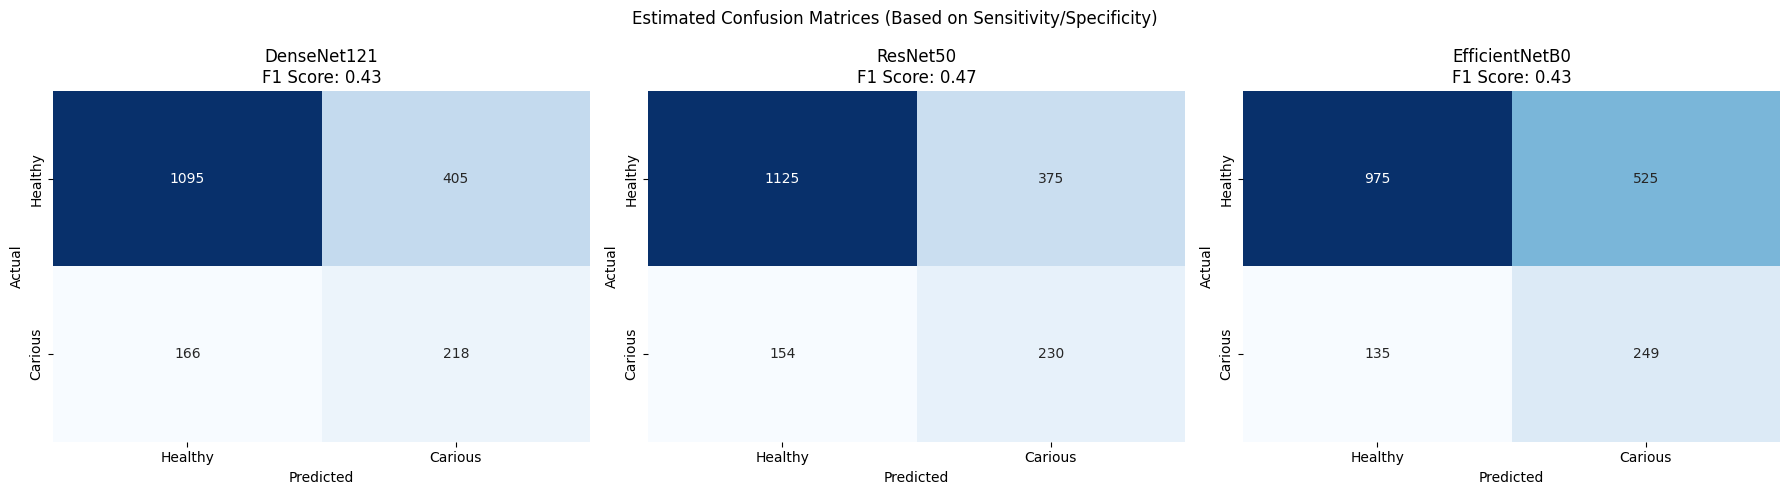

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample counts from your dataset setup
N_HEALTHY = 1500
N_CARIOUS = 384

# Provided average metrics
model_metrics = {
    "DenseNet121": {
        "sensitivity": 0.57,
        "specificity": 0.73,
        "f1": 0.43
    },
    "ResNet50": {
        "sensitivity": 0.60,
        "specificity": 0.75,
        "f1": 0.47
    },
    "EfficientNetB0": {
        "sensitivity": 0.65,
        "specificity": 0.65,
        "f1": 0.43
    }
}

# Estimate confusion matrices
conf_matrices = {}
for model, metrics in model_metrics.items():
    TP = int(metrics["sensitivity"] * N_CARIOUS)
    FN = N_CARIOUS - TP
    TN = int(metrics["specificity"] * N_HEALTHY)
    FP = N_HEALTHY - TN
    conf_matrices[model] = {
        "TP": TP, "FN": FN, "TN": TN, "FP": FP,
        "F1": metrics["f1"]
    }

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model, cm) in zip(axes, conf_matrices.items()):
    matrix = np.array([[cm["TN"], cm["FP"]],
                       [cm["FN"], cm["TP"]]])
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Healthy", "Carious"],
                yticklabels=["Healthy", "Carious"],
                ax=ax)
    ax.set_title(f"{model}\nF1 Score: {cm['F1']:.2f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("Estimated Confusion Matrices (Based on Sensitivity/Specificity)")
plt.tight_layout()
plt.show()


In [25]:
!pip install grad-cam


     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/7.8 MB 5.6 MB/s eta 0:00:02
     ---------- ----------------------------- 2.1/7.8 MB 5.6 MB/s eta 0:00:02
     -------------- ------------------------- 2.9/7.8 MB 4.8 MB/s eta 0:00:02
     -------------------- ------------------- 3.9/7.8 MB 4.9 MB/s eta 0:00:01
     ------------------------- -------------- 5.0/7.8 MB 5.2 MB/s eta 0:00:01
     ------------------------------ --------- 6.0/7.8 MB 5.4 MB/s eta 0:00:01
     ------------------------------------ --- 7.1/7.8 MB 5.0 MB/s eta 0:00:01
     ---------------------------------------- 7.8/7.8 MB 4.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): fin


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\shawn\AppData\Local\Temp\ipykernel_21428\2243793076.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_lo

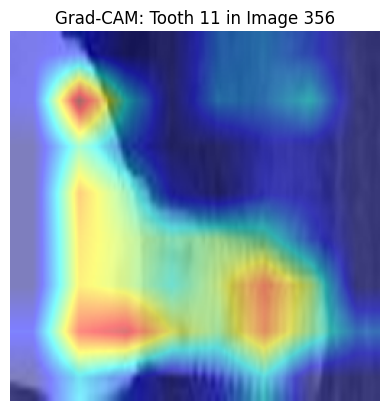

In [34]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === CONFIG ===
img_path = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops/356/tooth_11.jpg"
model_weights_path = "C:/Users/shawn/Downloads/SMART/resnet50_final_fold.pth"
IMG_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and preprocess image ===
image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension
input_np = np.array(image.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0

# === Load model ===
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Binary classification
model.load_state_dict(torch.load(model_weights_path, map_location=DEVICE))
model.eval().to(DEVICE)

# === Grad-CAM setup ===
target_layers = [model.layer4[-1]]  # final conv layer of ResNet50
cam = GradCAM(model=model, target_layers=target_layers)

# === Run Grad-CAM ===
targets = [ClassifierOutputTarget(1)]  # Class 1 = carious
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # Only one image

# === Overlay on image and display ===
visualization = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title("Grad-CAM: Tooth 11 in Image 356")
plt.axis('off')
plt.show()


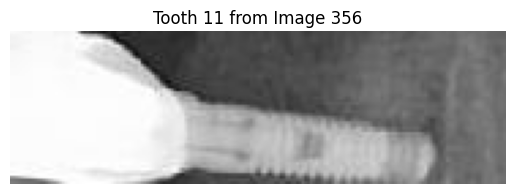

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image
img_path = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops/356/tooth_11.jpg"

# Load and display the image
image = Image.open(img_path).convert("RGB")

plt.imshow(image)
plt.title("Tooth 11 from Image 356")
plt.axis("off")
plt.show()


In [36]:
import pandas as pd
import os

# Load the labeled CSV file
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
img_dir = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops"

# Load data
df = pd.read_csv(csv_path)
df = df[df["Label"] == 1]  # Filter only carious teeth
df["Image_ID"] = df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
df["Filename"] = df.apply(lambda row: os.path.join(row["Image_ID"], f"tooth_{int(row['Tooth#'])}.jpg"), axis=1)

# Verify which files exist
df["Exists"] = df["Filename"].apply(lambda f: os.path.isfile(os.path.join(img_dir, f)))
valid_df = df[df["Exists"]].head(5)  # Pick 5 carious teeth with valid image paths

valid_df[["Image_ID", "Tooth#", "Filename"]]


,Image_ID,Tooth#,Filename
167,149,25,149\tooth_25.jpg
168,149,26,149\tooth_26.jpg
350,759,29,759\tooth_29.jpg
427,181,1,181\tooth_1.jpg
442,181,16,181\tooth_16.jpg


In [43]:
import pandas as pd

# Load the CSV file with labels
csv_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"
df = pd.read_csv(csv_path)

# Filter for carious teeth only (Label == 1)
carious_df = df[df["Label"] == 1].copy()

# Build file paths to the images
carious_df["Image_ID"] = carious_df["Image Name"].str.replace(".jpg", "", case=False).str.strip()
carious_df["Filename"] = carious_df.apply(lambda row: f"{row['Image_ID']}/tooth_{int(row['Tooth#'])}.jpg", axis=1)

# Show a sample of carious images (e.g., 10)
carious_sample = carious_df.sample(n=10, random_state=42)[["Image_ID", "Tooth#", "Filename"]]

print(carious_sample)


      Image_ID  Tooth#          Filename
21360      811      31  811/tooth_31.jpg
19666      513       5   513/tooth_5.jpg
5742        42      31   42/tooth_31.jpg
16449      180      19  180/tooth_19.jpg
9647       121      32  121/tooth_32.jpg
19178      770      19  770/tooth_19.jpg
5476       456      16  456/tooth_16.jpg
6197       427      18  427/tooth_18.jpg
20010      131      10  131/tooth_10.jpg
2308       444      27  444/tooth_27.jpg


C:\Users\shawn\AppData\Local\Temp\ipykernel_21428\426570748.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path, map_loc

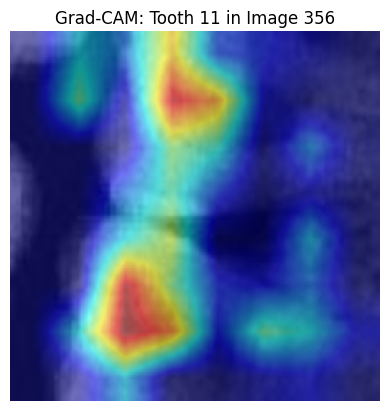

In [53]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === CONFIG ===
img_path = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops/811/tooth_31.jpg"
model_weights_path = "C:/Users/shawn/Downloads/SMART/resnet50_final_fold.pth"
IMG_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and preprocess image ===
image = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension
input_np = np.array(image.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0

# === Load model ===
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Binary classification
model.load_state_dict(torch.load(model_weights_path, map_location=DEVICE))
model.eval().to(DEVICE)

# === Grad-CAM setup ===
target_layers = [model.layer4[-1]]  # final conv layer of ResNet50
cam = GradCAM(model=model, target_layers=target_layers)

# === Run Grad-CAM ===
targets = [ClassifierOutputTarget(1)]  # Class 1 = carious
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # Only one image

# === Overlay on image and display ===
visualization = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title("Grad-CAM: Tooth 11 in Image 356")
plt.axis('off')
plt.show()


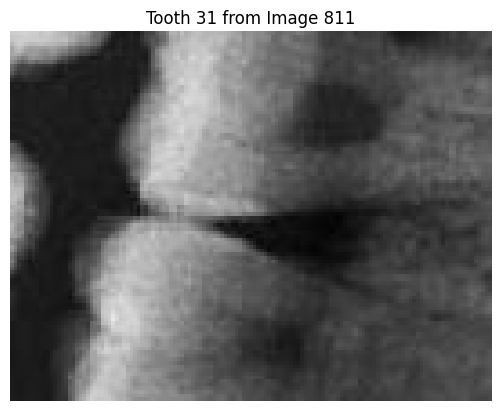

In [46]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image
img_path = "C:/Users/shawn/Downloads/SMART/BoundingBoxCrops/811/tooth_31.jpg"

# Load and display the image
image = Image.open(img_path).convert("RGB")

plt.imshow(image)
plt.title("Tooth 31 from Image 811")
plt.axis("off")
plt.show()
